<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Background_dependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 410 (delta 27), reused 10 (delta 10), pack-reused 350 (from 2)
Receiving objects: 100% (410/410), 60.39 MiB | 21.95 MiB/s, done.
Resolving deltas: 100% (135/135), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [3]:
# ============================================
# 📦 Load EC_t and X for all subjects
# ============================================

ECts = {}   # will hold EC_t arrays per subject
Xs   = {}   # will hold input X arrays per subject

for sid in subjects:
    ECt_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    X_path   = os.path.join(preproc_dir, f"{sid}_inputs.npy")

    if not os.path.exists(ECt_path):
        print(f"⚠️ Skipping {sid}: EC_t file not found.")
        continue
    if not os.path.exists(X_path):
        print(f"⚠️ Skipping {sid}: inputs file not found.")
        continue

    ECts[sid] = np.load(ECt_path)
    Xs[sid]   = np.load(X_path)

    print(f"✅ Loaded {sid}: EC_t {ECts[sid].shape}, X {Xs[sid].shape}")

print(f"\n🎯 Loaded {len(ECts)} subjects successfully.")


✅ Loaded id_100206: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100307: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100408: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101006: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101107: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101309: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101915: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102008: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102109: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102311: EC_t (500, 450, 450), X (4677, 1350)

🎯 Loaded 10 subjects successfully.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# =====================================================
# 🔹 Compute energy–effect correlation for all subjects
# =====================================================

results = []
scatter_data = {}  # optional: store per-subject arrays for later plotting

for sid in ECts.keys():
    EC_t = ECts[sid]
    X = Xs[sid]
    M, N = EC_t.shape[0], EC_t.shape[1]
    S = X.shape[1] // N

    # Energy of baseline state at time t
    x_t = X[:M, :]                      # last N entries = state at time t
    E_t = np.sum(x_t**2, axis=1)          # shape (M,)

    # Mean L2 perturbation magnitude at time t
    EC_mean_t = np.mean(np.sum(EC_t**2, axis=2), axis=1)   # shape (M,)

    # Correlation
    r, p = pearsonr(E_t, EC_mean_t)
    results.append(dict(subj=sid, r=r, p=p))

    scatter_data[sid] = (E_t, EC_mean_t)
    print(f"{sid}: r = {r:.3f}, p = {p:.2g}")

# Convert results to DataFrame
df_corr = pd.DataFrame(results)
print("\nAverage correlation across subjects:", df_corr['r'].mean())

id_100206: r = -0.614, p = 4.5e-53
id_100307: r = -0.605, p = 3.7e-51
id_100408: r = -0.530, p = 1.2e-37
id_101006: r = -0.714, p = 2.8e-79
id_101107: r = -0.682, p = 1.3e-69
id_101309: r = -0.693, p = 9e-73
id_101915: r = -0.615, p = 2.8e-53
id_102008: r = -0.505, p = 8.7e-34
id_102109: r = -0.611, p = 1.7e-52
id_102311: r = -0.402, p = 7.5e-21

Average correlation across subjects: -0.5971304295833089


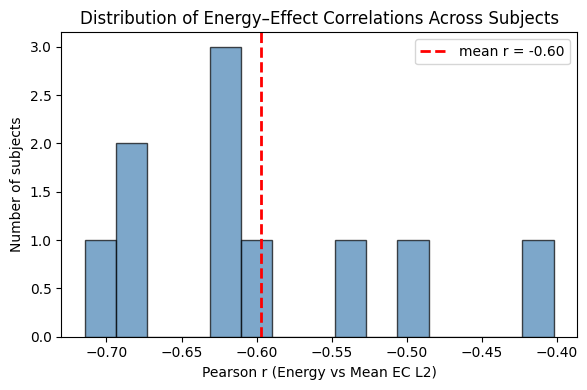

In [5]:
# =====================================================
# 📊 Histogram of correlation coefficients
# =====================================================
plt.figure(figsize=(6,4))
plt.hist(df_corr['r'], bins=15, color='steelblue', edgecolor='k', alpha=0.7)
plt.axvline(df_corr['r'].mean(), color='red', lw=2, linestyle='--', label=f"mean r = {df_corr['r'].mean():.2f}")
plt.xlabel("Pearson r (Energy vs Mean EC L2)")
plt.ylabel("Number of subjects")
plt.title("Distribution of Energy–Effect Correlations Across Subjects")
plt.legend()
plt.tight_layout()
plt.show()

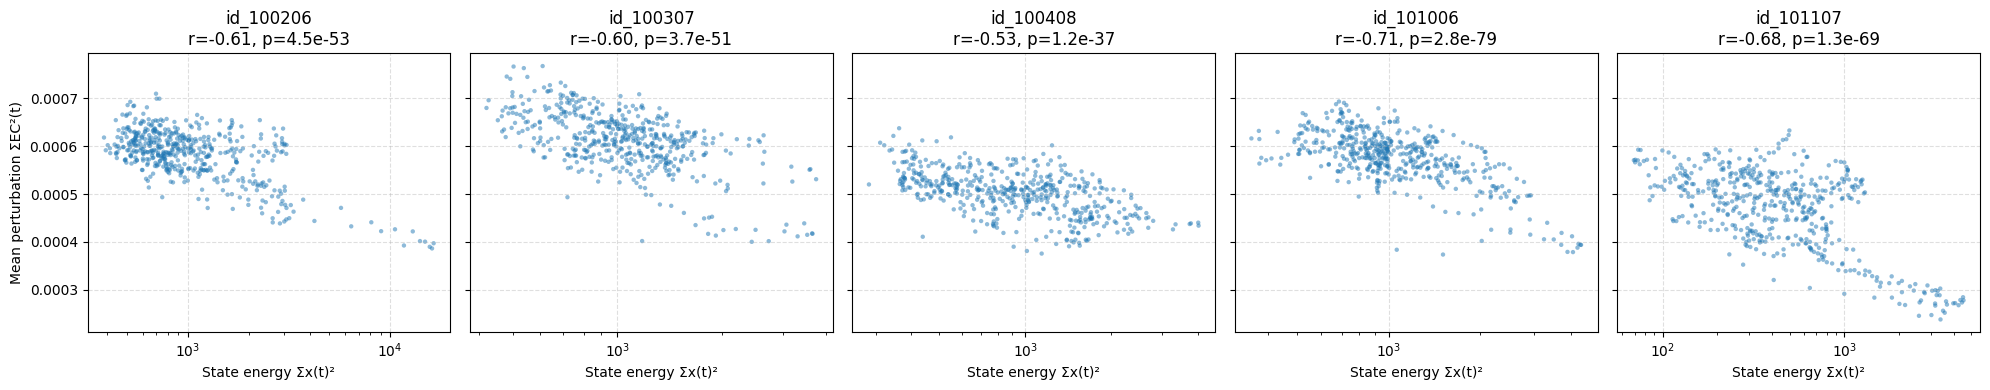

In [6]:
# =====================================================
# 📈 Scatter plots for selected subjects
# =====================================================
# Choose how many subjects to show (avoid too many subplots)
n_plot = min(5, len(scatter_data))  # plot up to 6 subjects
sel_subjects = list(scatter_data.keys())[:n_plot]

fig, axs = plt.subplots(1, n_plot, figsize=(4*n_plot, 4), sharey=True)
if n_plot == 1:
    axs = [axs]

for ax, sid in zip(axs, sel_subjects):
    E_t, EC_mean_t = scatter_data[sid]
    r = df_corr.loc[df_corr['subj'] == sid, 'r'].values[0]
    p = df_corr.loc[df_corr['subj'] == sid, 'p'].values[0]
    ax.scatter(E_t, EC_mean_t, s=10, alpha=0.5, edgecolors='none')
    ax.set_title(f"{sid}\nr={r:.2f}, p={p:.2g}")
    ax.set_xlabel("State energy Σx(t)²")
    ax.set_xscale('log')
    #ax.set_yscale('log')
    if ax == axs[0]:
        ax.set_ylabel("Mean perturbation ΣEC²(t)")
    ax.grid(ls='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [12]:
# --- Setup: Add safe globals for model loading ---
import torch.serialization
from src import NPI

torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

def load_model(model_path, inputs, targets):
    """Load a trained model from file."""
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

In [14]:
# =====================================================
# 🔹 Correlation: baseline energy vs. POST-stimulus energy
# =====================================================

results_post_stim = []
scatter_data_post = {}

for sid in ECts.keys():
    EC_t = ECts[sid]
    X = Xs[sid]
    M, N = EC_t.shape[0], EC_t.shape[1]
    S = X.shape[1] // N

    # Baseline state energy at time t (use only first M samples to match EC_t)
    x_t = X[:M, -N:]  # last N entries of each window = state at time t
    E_baseline = np.sum(x_t**2, axis=1)  # shape (M,)

    # Load trained model for this subject
    model_path = os.path.join(models_dir, f"{sid}_MLP.pt")
    if not os.path.exists(model_path):
        print(f"⚠️ Skipping {sid}: model not found.")
        continue

    model = load_model(model_path, X[:M], EC_t.mean(axis=(1,2)))

    # Baseline predictions at t+1 (unperturbed) - use same M samples as EC_t
    with torch.no_grad():
        y_baseline = model(torch.tensor(X[:M], dtype=torch.float, device=device)).detach().cpu().numpy()  # (M, N)

    # Average energy across all stimulated regions
    E_post_stim_all = []
    for j in range(N):
        y_perturbed_j = y_baseline + EC_t[:, j, :]  # (M, N) - state at t+1 with region j stimulated
        E_post_j = np.sum(y_perturbed_j**2, axis=1)  # (M,)
        E_post_stim_all.append(E_post_j)

    E_post_stim = np.mean(E_post_stim_all, axis=0)  # Average across all regions: (M,)

    # Correlation
    r, p = pearsonr(E_baseline, E_post_stim)
    results_post_stim.append(dict(subj=sid, r=r, p=p))
    scatter_data_post[sid] = (E_baseline, E_post_stim)
    print(f"{sid}: r = {r:.3f}, p = {p:.2g}")

    del model
    gc.collect()
    torch.cuda.empty_cache()

df_corr_post = pd.DataFrame(results_post_stim)
print("\nAverage correlation (baseline energy vs post-stim energy):", df_corr_post['r'].mean())

id_100206: r = 0.977, p = 0
id_100307: r = 0.970, p = 4.6e-309
id_100408: r = 0.977, p = 0
id_101006: r = 0.991, p = 0
id_101107: r = 0.986, p = 0
id_101309: r = 0.982, p = 0
id_101915: r = 0.975, p = 0
id_102008: r = 0.987, p = 0
id_102109: r = 0.979, p = 0
id_102311: r = 0.981, p = 0

Average correlation (baseline energy vs post-stim energy): 0.9806902439855545


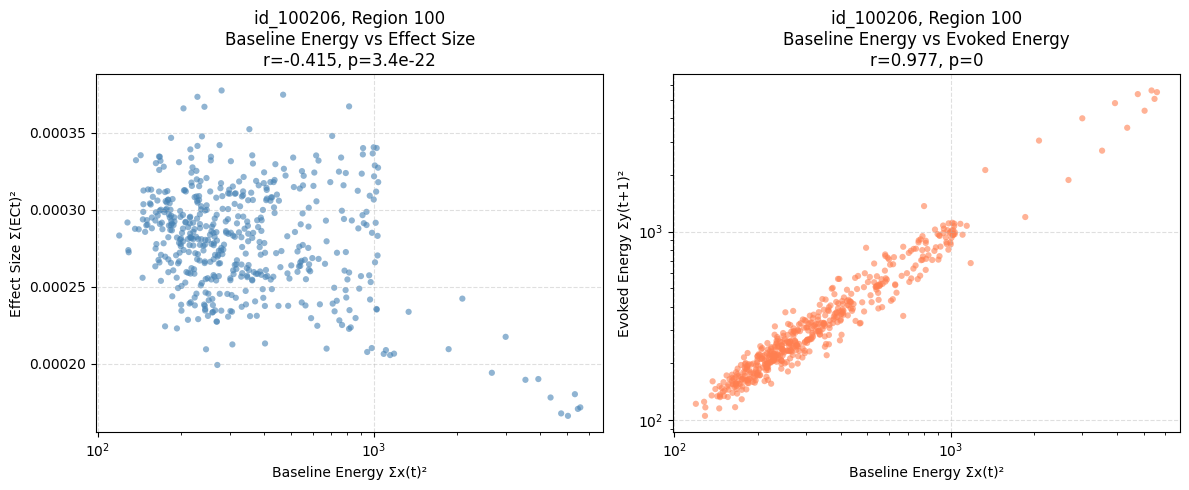

In [17]:
# =====================================================
# 📊 Scatter plots for specific subject and region
# =====================================================

# SELECT SUBJECT AND REGION
sid = subjects[0]  # change this to desired subject
reg = 100            # change this to desired region (0 to N-1)

EC_t = ECts[sid]
X = Xs[sid]
M, N = EC_t.shape[0], EC_t.shape[1]

# Baseline state energy at time t (use only first M samples to match EC_t)
x_t = X[:M, -N:]  # last N entries = state at time t
E_baseline = np.sum(x_t**2, axis=1)  # (M,)

# Effect size for this region: L2 norm of perturbation across all nodes
effect_size_reg = np.sum(EC_t[:, reg, :]**2, axis=1)  # (M,)

# Evoked energy: baseline prediction + perturbation for this region
model_path = os.path.join(models_dir, f"{sid}_MLP.pt")
model = load_model(model_path, X[:M], EC_t.mean(axis=(1,2)))

with torch.no_grad():
    y_baseline = model(torch.tensor(X[:M], dtype=torch.float, device=device)).detach().cpu().numpy()  # (M, N)

y_perturbed_reg = y_baseline + EC_t[:, reg, :]  # (M, N)
E_evoked = np.sum(y_perturbed_reg**2, axis=1)  # (M,)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Baseline energy vs Effect size
ax1.scatter(E_baseline, effect_size_reg, s=20, alpha=0.6, edgecolors='none', color='steelblue')
r1, p1 = pearsonr(E_baseline, effect_size_reg)
ax1.set_xlabel('Baseline Energy Σx(t)²')
ax1.set_ylabel('Effect Size Σ(ECt)²')
ax1.set_title(f'{sid}, Region {reg}\nBaseline Energy vs Effect Size\nr={r1:.3f}, p={p1:.2g}')
ax1.grid(ls='--', alpha=0.4)
ax1.set_xscale('log')

# Plot 2: Baseline energy vs Evoked energy
ax2.scatter(E_baseline, E_evoked, s=20, alpha=0.6, edgecolors='none', color='coral')
r2, p2 = pearsonr(E_baseline, E_evoked)
ax2.set_xlabel('Baseline Energy Σx(t)²')
ax2.set_ylabel('Evoked Energy Σy(t+1)²')
ax2.set_title(f'{sid}, Region {reg}\nBaseline Energy vs Evoked Energy\nr={r2:.3f}, p={p2:.2g}')
ax2.grid(ls='--', alpha=0.4)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

del model
gc.collect()
torch.cuda.empty_cache()

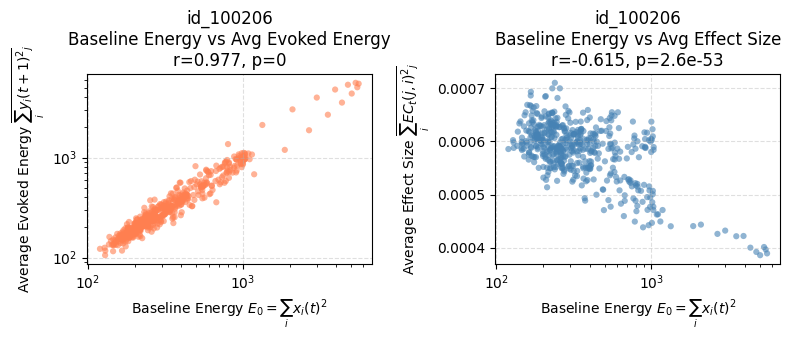

In [24]:
# =====================================================
# 📊 Scatter plots: baseline energy vs AVERAGE effects across all regions
# =====================================================

# SELECT SUBJECT
sid = subjects[0]  # change this to desired subject

EC_t = ECts[sid]
X = Xs[sid]
M, N = EC_t.shape[0], EC_t.shape[1]

# Baseline state energy at time t (use only first M samples to match EC_t)
x_t = X[:M, -N:]  # last N entries = state at time t
E_baseline = np.sum(x_t**2, axis=1)  # (M,)

# Average effect size across all regions: mean L2 norm of EC_t
effect_size_avg = np.mean(np.sum(EC_t**2, axis=2), axis=1)  # (M,)

# Load model
model_path = os.path.join(models_dir, f"{sid}_MLP.pt")
model = load_model(model_path, X[:M], EC_t.mean(axis=(1,2)))

with torch.no_grad():
    y_baseline = model(torch.tensor(X[:M], dtype=torch.float, device=device)).detach().cpu().numpy()  # (M, N)

# Average evoked energy across all stimulated regions
E_evoked_all = []
for j in range(N):
    y_perturbed_j = y_baseline + EC_t[:, j, :]  # (M, N) - state with region j stimulated
    E_perturbed_j = np.sum(y_perturbed_j**2, axis=1)  # (M,)
    E_evoked_all.append(E_perturbed_j)

E_evoked_avg = np.mean(E_evoked_all, axis=0)  # (M,) - average across all regions

# Create two subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(8, 3.5))

# Plot 1: Baseline energy vs Average effect size
ax1.scatter(E_baseline, effect_size_avg, s=20, alpha=0.6, edgecolors='none', color='steelblue')
r1, p1 = pearsonr(E_baseline, effect_size_avg)
ax1.set_xlabel(r'Baseline Energy $E_0 = \sum_i x_i(t)^2$')
ax1.set_ylabel(r'Average Effect Size $\overline{\sum_i EC_t(j,i)^2}_j$')
ax1.set_title(f'{sid}\nBaseline Energy vs Avg Effect Size\nr={r1:.3f}, p={p1:.2g}')
ax1.grid(ls='--', alpha=0.4)
ax1.set_xscale('log')

# Plot 2: Baseline energy vs Average evoked energy
ax2.scatter(E_baseline, E_evoked_avg, s=20, alpha=0.6, edgecolors='none', color='coral')
r2, p2 = pearsonr(E_baseline, E_evoked_avg)
ax2.set_xlabel(r'Baseline Energy $E_0 = \sum_i x_i(t)^2$')
ax2.set_ylabel(r'Average Evoked Energy $\overline{\sum_i y_i(t+1)^2}_j$')
ax2.set_title(f'{sid}\nBaseline Energy vs Avg Evoked Energy\nr={r2:.3f}, p={p2:.2g}')
ax2.grid(ls='--', alpha=0.4)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

del model
gc.collect()
torch.cuda.empty_cache()

# Network dependence of background dependence

### 1) Show that the magnitude of the effects depends on which region is being stimulated (responsiveness). Group by networks. Search correlations with receptor densities.
### 2) Show that the relation between pre-stimulus energy and post-stimulus effects (pre-to-post correlation) depends on which region is being stimulated. We hypothesize that effects of stimulating primary networks are more predictable from the pre-state, compared to stimulating associative networks.

# Hierarchyness

In [ ]:
# import numpy as np
# from numpy.linalg import solve

# def compute_hierarchy_and_trophic_coherence(EC: np.ndarray):
#     """
#     Compute hierarchical levels (gamma) and trophic coherence from an
#     asymmetric effective connectivity matrix EC.

#     Parameters
#     ----------
#     EC : (N, N) array_like
#         Effective connectivity matrix; EC[i, j] is the influence of region i on region j
#         (rows = sources, columns = targets).

#     Returns
#     -------
#     gamma : (N,) ndarray
#         Hierarchical level of each node (shifted so that min(gamma) = 0).
#     trophic_coherence : float
#         Scalar measure between roughly 0 and 1; higher = more coherent hierarchy.
#     """
#     # If EC is already rows=source, cols=target, then A = EC
#     A = np.asarray(EC, dtype=float)

#     # Column sums: total outgoing weight from each node (out-strength)
#     d = A.sum(axis=0)  # shape (N,)

#     # Row sums: total incoming weight to each node (in-strength)
#     delta = A.sum(axis=1)  # shape (N,)

#     # u = in + out; v = out - in
#     u = d + delta
#     v = d - delta

#     # Build Lambda = diag(u) - A - A'
#     Lambda = np.diag(u) - A - A.T

#     # Fix one diagonal entry to 0 to make the system solvable/anchored
#     Lambda[0, 0] = 0.0

#     # Solve Lambda * gamma = v
#     gamma = solve(Lambda, v)

#     # Shift so the minimum hierarchical level is 0
#     gamma = gamma - gamma.min()

#     # Build matrix of squared deviations from "ideal" trophic step of 1
#     X, Y = np.meshgrid(gamma, gamma)
#     H = (X - Y - 1.0)**2

#     # Compute weighted mean squared trophic distance
#     F0 = np.sum(A * H) / np.sum(A)

#     # Trophic coherence = 1 - F0
#     trophic_coherence = 1.0 - F0

#     return gamma, trophic_coherence



# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from scipy.stats import pearsonr

# # =====================================================
# # 🔹 Compute energy–effect correlation for all subjects
# # =====================================================

# results = []
# scatter_data = {}  # optional: store per-subject arrays for later plotting

# for sid in ECts.keys():
#     EC_t = ECts[sid]
#     X = Xs[sid]
#     M, N = EC_t.shape[0], EC_t.shape[1]
#     S = X.shape[1] // N

#     # Energy of baseline state at time t
#     x_t = X[:M, :]                      # last N entries = state at time t
#     E_t = np.sum(x_t**2, axis=1)          # shape (M,)

#     # Mean L2 perturbation magnitude at time t
#     HierarC=np.zeros((M,N))
#     TropiC=np.zeros(M)
#     for i in range(M):
#       HierarC[i,:]=compute_hierarchy_and_trophic_coherence(EC_t[i,:,:])[0]
#       TropiC[i]=compute_hierarchy_and_trophic_coherence(EC_t[i,:,:])[1]  # shape (M,)

#     H=np.mean(HierarC,axis=1)

#     # Correlation
#     r, p = pearsonr(E_t, TropiC+H)
#     results.append(dict(subj=sid, r=r, p=p))

#     scatter_data[sid] = (E_t, TropiC+H)
#     print(f"{sid}: r = {r:.3f}, p = {p:.2g}")

# # Convert results to DataFrame
# df_corr = pd.DataFrame(results)
# print("\nAverage correlation across subjects:", df_corr['r'].mean())